In [1]:
from torchvision import transforms

# Resize to 256x256 and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts to [0,1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Now in [-1, 1]
])

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        self.transform = transform
        self.files_A = sorted([os.path.join(root_A, f) for f in os.listdir(root_A) if f.endswith(".jpg")])
        self.files_B = sorted([os.path.join(root_B, f) for f in os.listdir(root_B) if f.endswith(".jpg")])

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

    def __getitem__(self, idx):
        img_A = Image.open(self.files_A[idx]).convert("RGB")
        img_B = Image.open(self.files_B[idx]).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}


In [3]:
from torch.utils.data import DataLoader

dataset = ImageDataset("/kaggle/input/monet2photo/trainA", "/kaggle/input/monet2photo/trainB", transform=transform)


In [4]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [5]:
for i, batch in enumerate(dataloader):
    print(batch["A"].shape, batch["B"].shape)
    break

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


generator

In [6]:
# models/generator.py
import torch.nn as nn

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_blocks=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]
        # Downsample
        in_features = 64
        for _ in range(2):
            out_features = in_features * 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # ResBlocks
        for _ in range(n_blocks):
            model += [ResnetBlock(in_features)]

        # Upsample
        for _ in range(2):
            out_features = in_features // 2
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


discriminator

In [7]:
# models/discriminator.py
import torch.nn as nn

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_feat, out_feat, norm=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, norm=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)


loss

In [8]:
adv_criterion = nn.MSELoss()  # For LSGAN (better stability)

Cycle Consistency Loss

In [9]:
cycle_criterion = nn.L1Loss()

identity loss

In [10]:
identity_criterion = nn.L1Loss()

training loop

In [11]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 50

In [12]:
G_A2B = ResnetGenerator().to(device)
G_B2A = ResnetGenerator().to(device)
D_A = PatchDiscriminator().to(device)
D_B = PatchDiscriminator().to(device)

In [13]:
import torch.optim as optim

# Combine parameters of both generators
optimizer_G = optim.Adam(
    list(G_A2B.parameters()) + list(G_B2A.parameters()), 
    lr=0.0002, 
    betas=(0.5, 0.999)
)

# Optimizers for discriminators
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [14]:
lambda_identity = 5.0
lambda_cycle = 10.0

In [15]:
import matplotlib.pyplot as plt

# Store loss history
G_losses = []
D_A_losses = []
D_B_losses = []
epoch_times = []

In [16]:
import time

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Track start time of epoch
    total_loss_G = 0
    total_loss_D_A = 0
    total_loss_D_B = 0
    total_batches = len(dataloader)

    for batch_idx, batch in enumerate(dataloader):
        batch_start_time = time.time()  # Track start time of batch

        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        # === Train Generators ===
        optimizer_G.zero_grad()

        # Identity loss
        same_B = G_A2B(real_B)
        same_A = G_B2A(real_A)
        loss_id_A = identity_criterion(same_A, real_A) * lambda_identity
        loss_id_B = identity_criterion(same_B, real_B) * lambda_identity

        # GAN loss
        fake_B = G_A2B(real_A)
        pred_fake_B = D_B(fake_B)
        loss_GAN_A2B = adv_criterion(pred_fake_B, torch.ones_like(pred_fake_B))

        fake_A = G_B2A(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_B2A = adv_criterion(pred_fake_A, torch.ones_like(pred_fake_A))

        # Cycle loss
        rec_A = G_B2A(fake_B)
        rec_B = G_A2B(fake_A)
        loss_cycle_A = cycle_criterion(rec_A, real_A) * lambda_cycle
        loss_cycle_B = cycle_criterion(rec_B, real_B) * lambda_cycle

        # Total generator loss
        loss_G = loss_id_A + loss_id_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        optimizer_G.step()

        # === Train Discriminators ===
        optimizer_D_A.zero_grad()
        pred_real_A = D_A(real_A)
        pred_fake_A = D_A(fake_A.detach())
        loss_D_real_A = adv_criterion(pred_real_A, torch.ones_like(pred_real_A))
        loss_D_fake_A = adv_criterion(pred_fake_A, torch.zeros_like(pred_fake_A))
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        pred_real_B = D_B(real_B)
        pred_fake_B = D_B(fake_B.detach())
        loss_D_real_B = adv_criterion(pred_real_B, torch.ones_like(pred_real_B))
        loss_D_fake_B = adv_criterion(pred_fake_B, torch.zeros_like(pred_fake_B))
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # Accumulate losses
        total_loss_G += loss_G.item()
        total_loss_D_A += loss_D_A.item()
        total_loss_D_B += loss_D_B.item()

        # Track time per batch
        batch_time = time.time() - batch_start_time
        remaining_batches = total_batches - (batch_idx + 1)
        estimated_time_left = batch_time * remaining_batches
        print(f"Batch {batch_idx+1}/{total_batches} completed in {batch_time:.2f} seconds. Estimated time left: {estimated_time_left/60:.2f} minutes.", end='\r')

    # After all batches in an epoch, print the total results
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    G_losses.append(total_loss_G / total_batches)
    D_A_losses.append(total_loss_D_A / total_batches)
    D_B_losses.append(total_loss_D_B / total_batches)
    epoch_times.append(epoch_duration / 60)  # Save time in minutes

    print(f"\nEpoch [{epoch+1}/{num_epochs}] completed in {epoch_duration/60:.2f} minutes.")
    print(f"  Generator Loss: {total_loss_G/total_batches:.4f}")
    print(f"  Discriminator A Loss: {total_loss_D_A/total_batches:.4f}")
    print(f"  Discriminator B Loss: {total_loss_D_B/total_batches:.4f}")


Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [1/50] completed in 5.88 minutes.
  Generator Loss: 9.4155
  Discriminator A Loss: 0.2321
  Discriminator B Loss: 0.2305
Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [2/50] completed in 5.71 minutes.
  Generator Loss: 8.2792
  Discriminator A Loss: 0.2062
  Discriminator B Loss: 0.2025
Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [3/50] completed in 5.71 minutes.
  Generator Loss: 7.8202
  Discriminator A Loss: 0.2010
  Discriminator B Loss: 0.1926
Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [4/50] completed in 5.71 minutes.
  Generator Loss: 7.4974
  Discriminator A Loss: 0.1956
  Discriminator B Loss: 0.1877
Batch 1072/1072 completed in 0.31 seconds. Estimated time left: 0.00 minutes.
Epoch [5/50] completed in 5.71 minutes.
  Generator Loss: 7.2597
  Discriminator A Loss: 0.1933
  Disc

save models

In [17]:
torch.save(G_A2B.state_dict(), "G_A2B.pth")
torch.save(G_B2A.state_dict(), "G_B2A.pth")
torch.save(D_A.state_dict(), "D_A.pth")
torch.save(D_B.state_dict(), "D_B.pth")

plotting

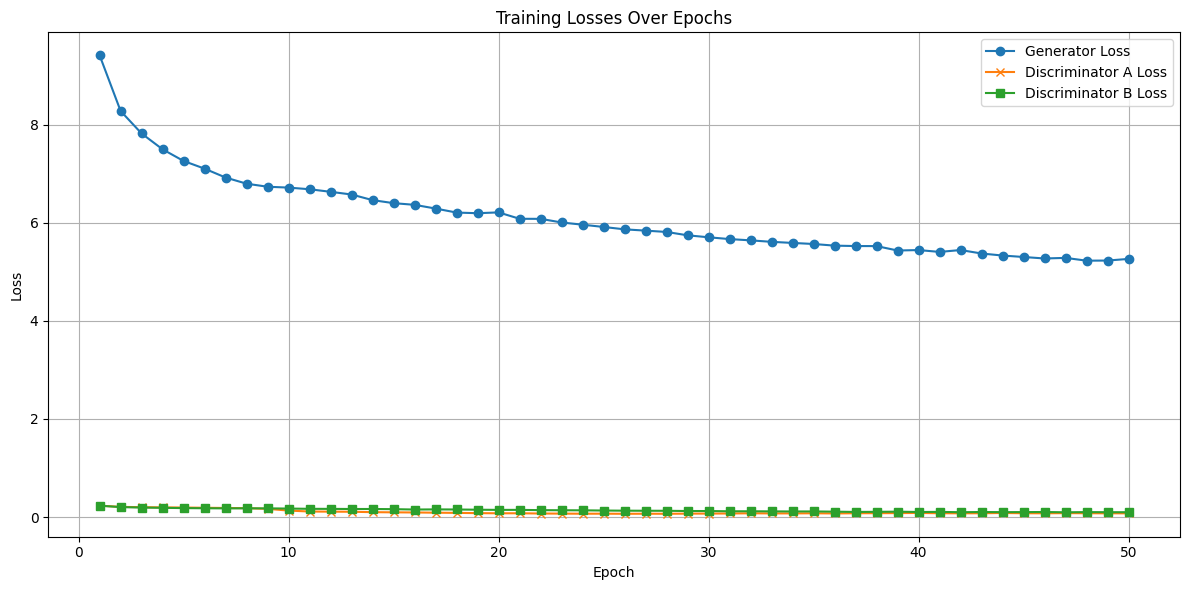

In [18]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Plot Generator loss
plt.plot(epochs, G_losses, label='Generator Loss', marker='o')

# Plot Discriminator losses
plt.plot(epochs, D_A_losses, label='Discriminator A Loss', marker='x')
plt.plot(epochs, D_B_losses, label='Discriminator B Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

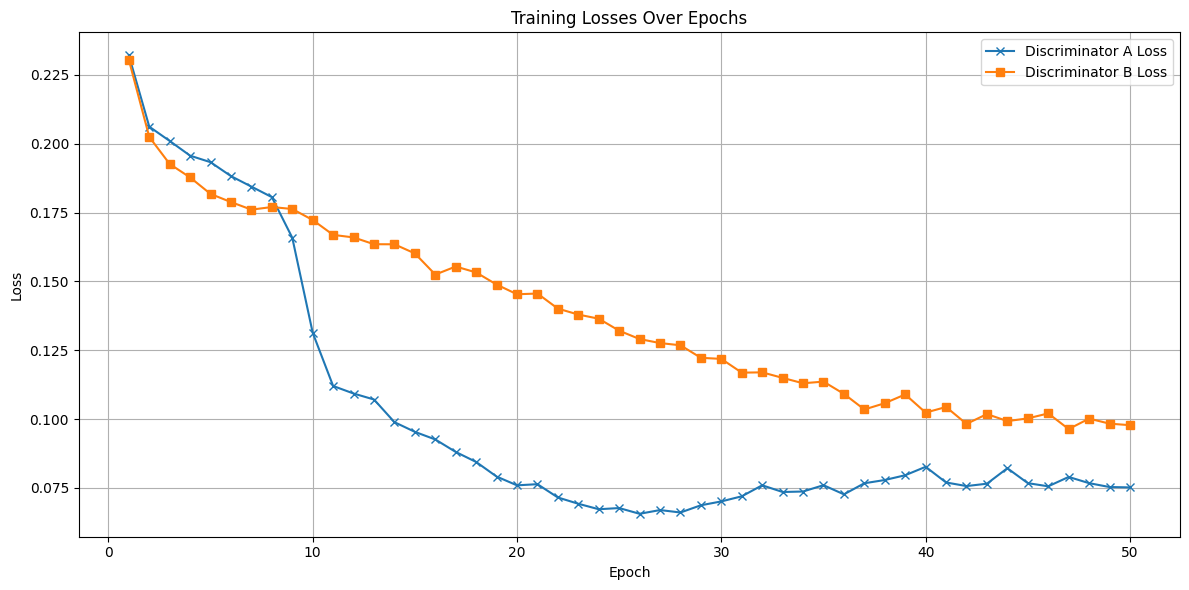

In [27]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Plot Discriminator losses
plt.plot(epochs, D_A_losses, label='Discriminator A Loss', marker='x')
plt.plot(epochs, D_B_losses, label='Discriminator B Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

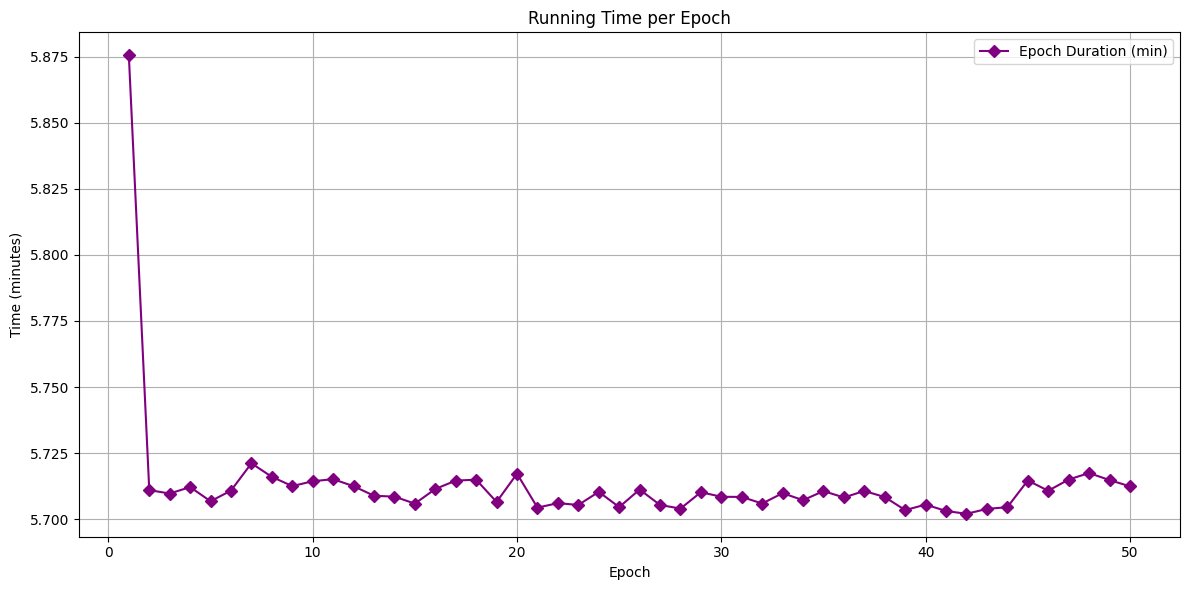

In [19]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, epoch_times, label='Epoch Duration (min)', marker='D', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Time (minutes)')
plt.title('Running Time per Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

evaluation

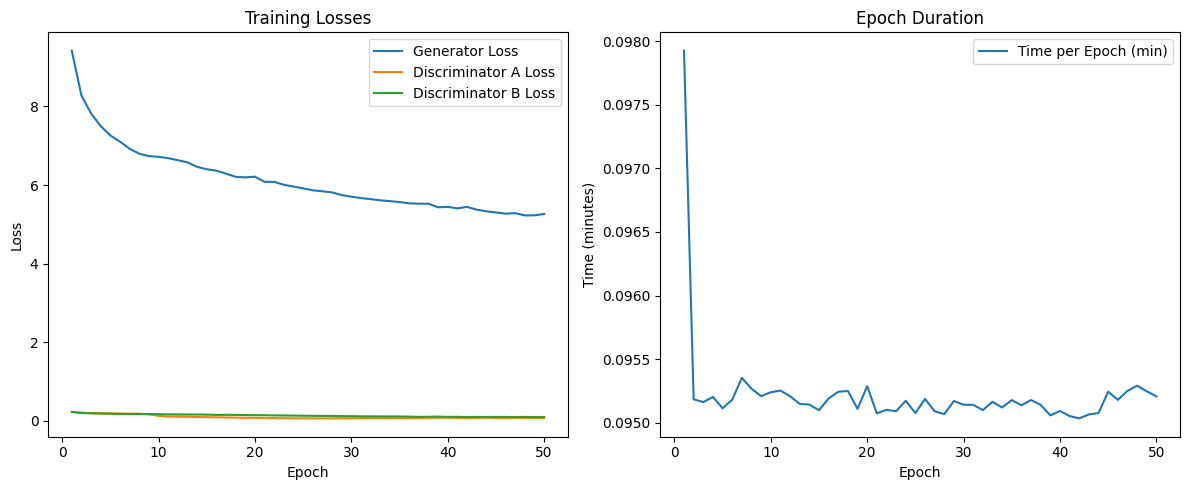

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot generator and discriminator losses
plt.subplot(1, 2, 1)
plt.plot(epochs, G_losses, label='Generator Loss')
plt.plot(epochs, D_A_losses, label='Discriminator A Loss')
plt.plot(epochs, D_B_losses, label='Discriminator B Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()

# Plot time per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, [t / 60 for t in epoch_times], label='Time per Epoch (min)')
plt.xlabel("Epoch")
plt.ylabel("Time (minutes)")
plt.title("Epoch Duration")
plt.legend()

plt.tight_layout()
plt.show()


test

In [21]:
test_dataset = ImageDataset("/kaggle/input/monet2photo/testA", "/kaggle/input/monet2photo/testB", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

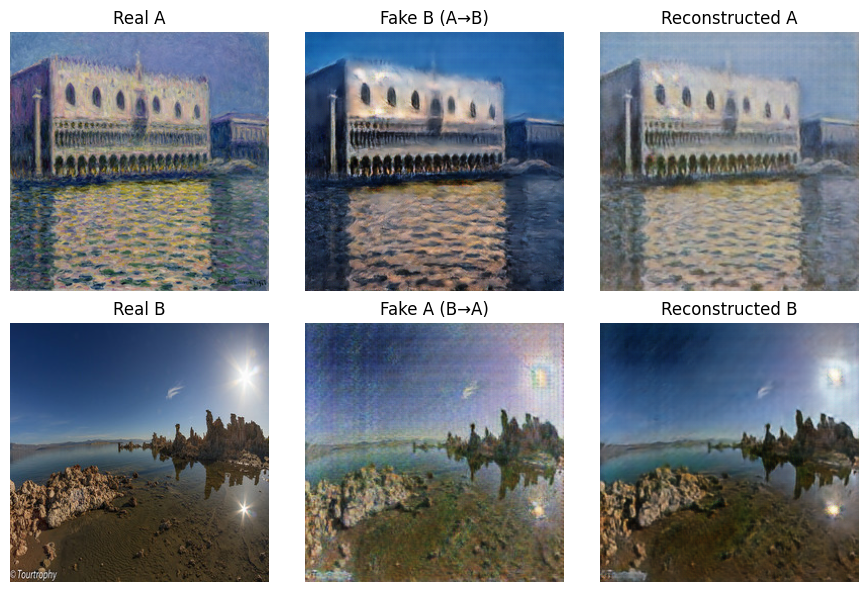

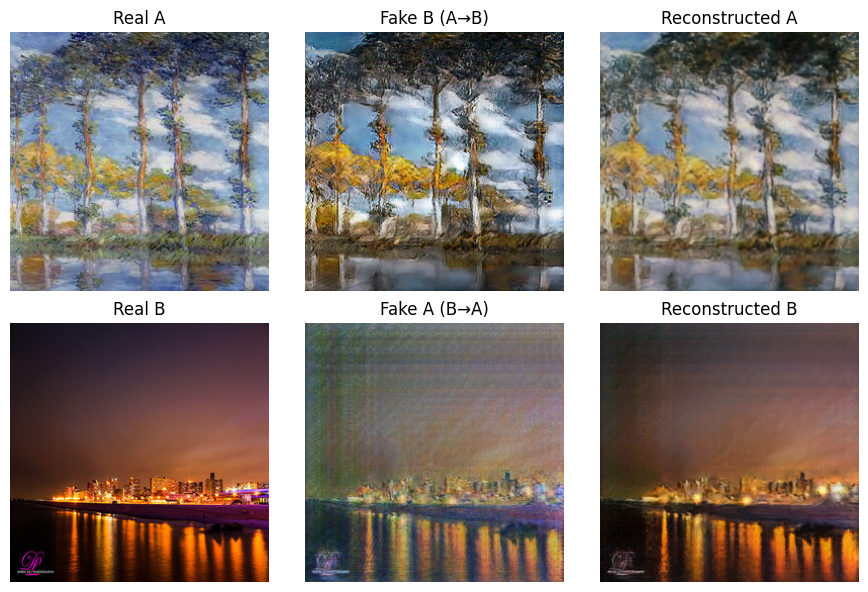

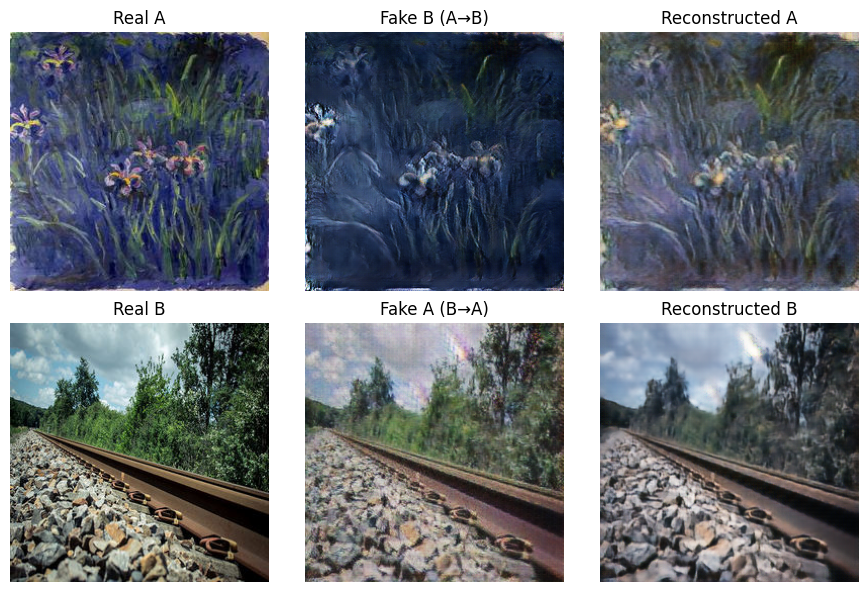

In [22]:
import torch
import matplotlib.pyplot as plt

def imshow(tensor, title):
    image = tensor.cpu().clone().detach()
    image = image.squeeze(0)
    image = (image + 1) / 2  # from [-1, 1] to [0, 1]
    np_img = image.numpy().transpose((1, 2, 0))
    plt.imshow(np_img)
    plt.title(title)
    plt.axis('off')

# Display a few test results
with torch.no_grad():
    for i, batch in enumerate(test_dataloader):
        if i >= 3: break  # show 3 examples

        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)

        plt.figure(figsize=(9, 6))

        plt.subplot(2, 3, 1)
        imshow(real_A[0], "Real A")

        plt.subplot(2, 3, 2)
        imshow(fake_B[0], "Fake B (A→B)")

        plt.subplot(2, 3, 3)
        imshow(G_B2A(fake_B)[0], "Reconstructed A")

        plt.subplot(2, 3, 4)
        imshow(real_B[0], "Real B")

        plt.subplot(2, 3, 5)
        imshow(fake_A[0], "Fake A (B→A)")

        plt.subplot(2, 3, 6)
        imshow(G_A2B(fake_A)[0], "Reconstructed B")

        plt.tight_layout()
        plt.show()

evaluation

In [23]:
import matplotlib.pyplot as plt

def show_translation_results(real_A, real_B, G_A2B, G_B2A, device):
    G_A2B.eval()
    G_B2A.eval()

    with torch.no_grad():
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        fake_B = G_A2B(real_A)
        fake_A = G_B2A(real_B)
        rec_A = G_B2A(fake_B)
        rec_B = G_A2B(fake_A)

    images = [real_A[0], fake_B[0], rec_A[0], real_B[0], fake_A[0], rec_B[0]]
    titles = ["Real A", "Fake B", "Reconstructed A", "Real B", "Fake A", "Reconstructed B"]

    plt.figure(figsize=(12, 6))
    for i in range(6):
        img = (images[i].cpu().detach() + 1) / 2  # Normalize from [-1, 1] to [0, 1]
        img = img.permute(1, 2, 0).numpy()
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


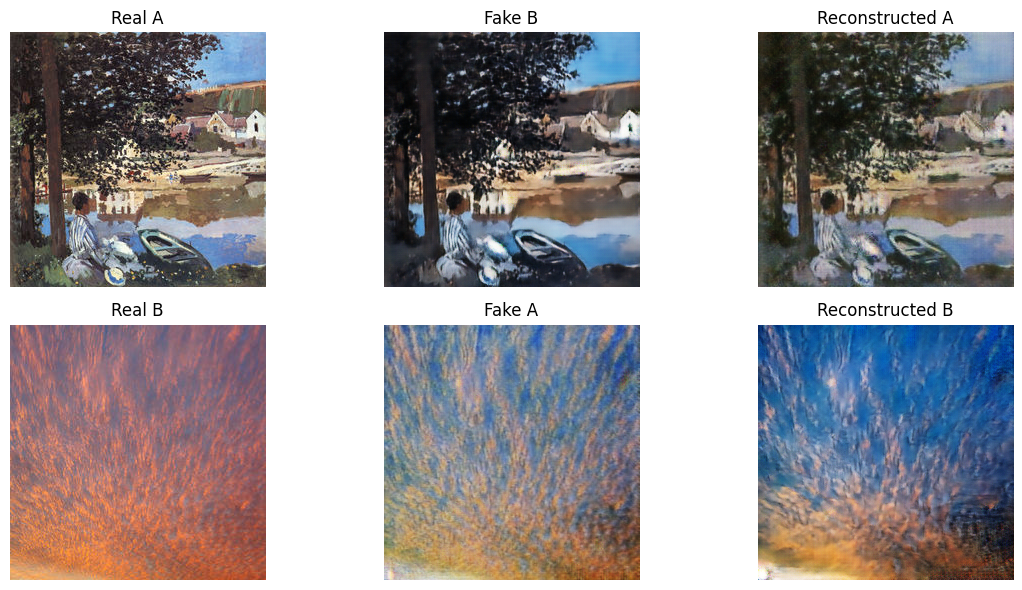

In [24]:
real_batch = next(iter(test_dataloader))
show_translation_results(real_batch["A"], real_batch["B"], G_A2B, G_B2A, device)

In [25]:
with torch.no_grad():
    total_cycle_loss = 0
    for batch in test_dataloader:
        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        fake_B = G_A2B(real_A)
        rec_A = G_B2A(fake_B)

        fake_A = G_B2A(real_B)
        rec_B = G_A2B(fake_A)

        loss_cycle_A = cycle_criterion(rec_A, real_A)
        loss_cycle_B = cycle_criterion(rec_B, real_B)

        total_cycle_loss += (loss_cycle_A + loss_cycle_B).item()

    avg_cycle_loss = total_cycle_loss / len(test_dataloader)
    print(f"Average Cycle Consistency Loss on Test Set: {avg_cycle_loss:.4f}")


Average Cycle Consistency Loss on Test Set: 0.2965


In [30]:
import torchvision.utils as vutils
import os

def save_fake_images(generator, dataloader, path, source='A'):
    os.makedirs(path, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            img = data[source].to(device)
            fake = generator(img)
            vutils.save_image(fake, f"{path}/{i}.png", normalize=True)

# Example usage:
save_fake_images(G_A2B, test_dataloader, "./generated_B_from_A", source="A")
save_fake_images(G_B2A, test_dataloader, "./generated_A_from_B", source="B")

In [ ]:
# Compare real B to generated B
pytorch-fid path_to_real_B path_to_generated_B_from_A

In [32]:
pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [33]:
import lpips
from torchvision import transforms

lpips_loss = lpips.LPIPS(net='alex').to(device)  # AlexNet-based perceptual metric

def compute_lpips(model1, model2, dataloader):
    lpips_values = []
    model1.eval()
    model2.eval()
    for batch in dataloader:
        img = batch["A"].to(device)
        with torch.no_grad():
            translated = model1(img)
            cycled = model2(translated)
            loss = lpips_loss(img, cycled)
            lpips_values.append(loss.item())
    return sum(lpips_values) / len(lpips_values)

avg_lpips = compute_lpips(G_A2B, G_B2A, test_dataloader)
print(f"Average LPIPS: {avg_lpips:.4f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 236MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

Average LPIPS: 0.3765


In [37]:
pip install torch-fidelity

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install torchmetrics[image]

Note: you may need to restart the kernel to use updated packages.


In [41]:
from torchmetrics.image.inception import InceptionScore

metric = InceptionScore(normalize=True).to(device)

for batch in test_dataloader:
    images = batch["A"].to(device)  # or "B", depending on your direction
    preds = G_A2B(images)
    metric.update(preds)

score, std = metric.compute()
print(f"Inception Score: {score:.4f} ± {std:.4f}")


ModuleNotFoundError: InceptionScore metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [35]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

def save_and_display_fake_images(generator, dataloader, path, source='A', max_images=5):
    os.makedirs(path, exist_ok=True)
    generator.eval()
    
    count = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if count >= max_images:
                break

            img = data[source].to(device)
            fake = generator(img)

            # Display the image
            grid = vutils.make_grid(fake, normalize=True)
            npimg = grid.cpu().numpy().transpose((1, 2, 0))
            plt.figure(figsize=(4, 4))
            plt.imshow(npimg)
            plt.title(f'{source} → Fake')
            plt.axis('off')
            plt.show()

            # Save the image
            vutils.save_image(fake, f"{path}/{i}.png", normalize=True)
            count += 1

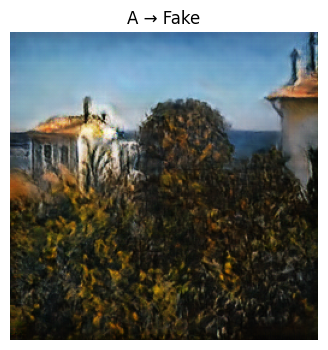

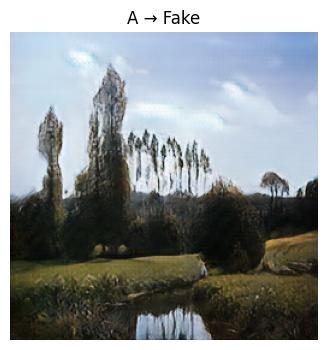

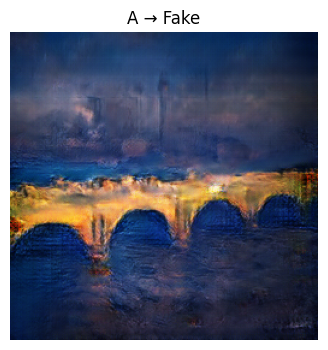

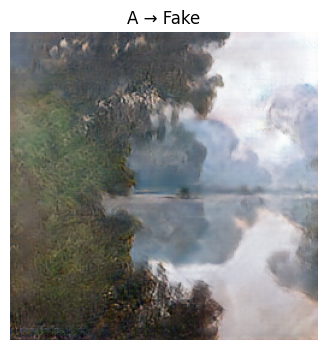

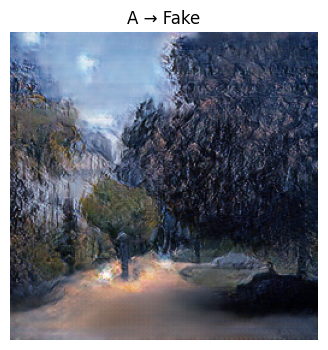

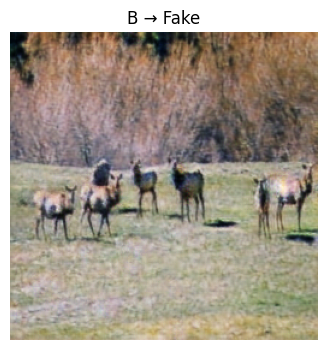

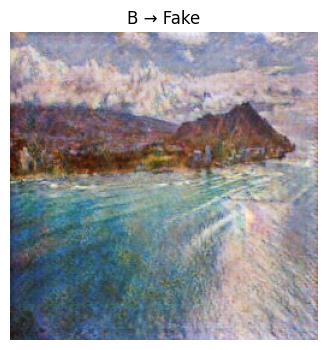

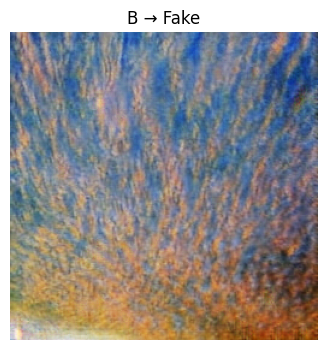

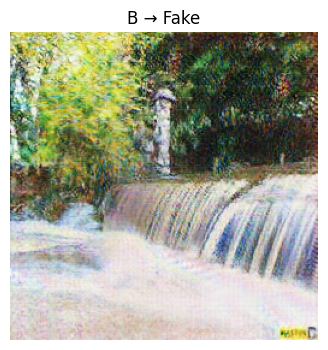

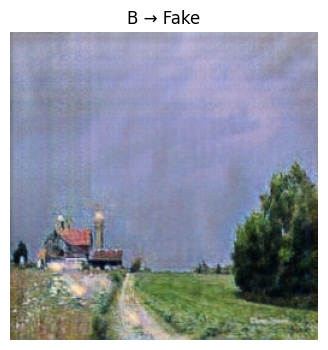

In [36]:
# Display and save max 5 examples
save_and_display_fake_images(G_A2B, test_dataloader, "./generated_B_from_A", source="A", max_images=5)
save_and_display_fake_images(G_B2A, test_dataloader, "./generated_A_from_B", source="B", max_images=5)

In [42]:
!zip -r output.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/G_B2A.pth (deflated 7%)
  adding: kaggle/working/generated_A_from_B/ (stored 0%)
  adding: kaggle/working/generated_A_from_B/102.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/67.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/51.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/119.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/39.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/79.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/112.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/25.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/96.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/118.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/97.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/56.png (deflated 0%)
  adding: kaggle/working/generated_A_from_B/13.png (deflated 0%)
  addin